# Using tensorflow_datasets

This notebook is based on the documentation https://www.tensorflow.org/datasets/keras_example. I expanded the example, adding example plots as well as plotting the loss function and accuracy over the epochs. Furthermore, my model is different, I added a convolutional layer. Adding this layer resulted to imporoved validation loss and accuracy, compared to the tensorflow example.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:

print(ds_info.splits["train"].num_examples)
print(ds_info.splits["test"].num_examples)
print(ds_info.features["label"].num_classes)

60000
10000
10


In [4]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

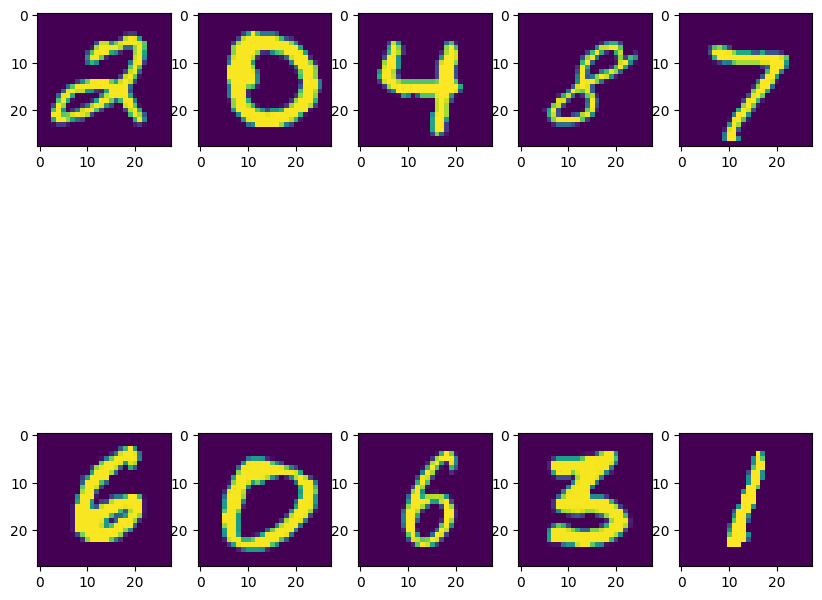

In [5]:
# Plotting some examples:

import matplotlib.pyplot as plt
plt.figure(figsize= (10, 10))

for i in range(11):
  for images, labels in ds_test.take(i):
    ax = plt.subplot(2, 5, i)
    plt.imshow(images.numpy().astype("uint8"))


In [7]:
# transforming and scaling images (uint8 to float 32):
# cache and prefetch are added for performance:

def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)



In [8]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [9]:
# Evaluation pipeline:

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [10]:
# Building the model:

cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28, 28,1)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=10))
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693962 (2.65 MB)
Trainable params: 693962 (2.65 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [11]:
cnn.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [12]:
history = cnn.fit(x = ds_train, validation_data = ds_test, epochs = 6)

Epoch 1/6
469/469 [==============================] - 40s 66ms/step - loss: 0.2313 - sparse_categorical_accuracy: 0.9325 - val_loss: 0.1141 - val_sparse_categorical_accuracy: 0.9648
Epoch 2/6
469/469 [==============================] - 26s 55ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9779 - val_loss: 0.0623 - val_sparse_categorical_accuracy: 0.9802
Epoch 3/6
469/469 [==============================] - 26s 55ms/step - loss: 0.0489 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.0481 - val_sparse_categorical_accuracy: 0.9832
Epoch 4/6
469/469 [==============================] - 26s 55ms/step - loss: 0.0359 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.0466 - val_sparse_categorical_accuracy: 0.9837
Epoch 5/6
469/469 [==============================] - 26s 55ms/step - loss: 0.0272 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.0486 - val_sparse_categorical_accuracy: 0.9834
Epoch 6/6
469/469 [==============================] - 25s 54ms/step - loss: 0.0205 - sparse_cate

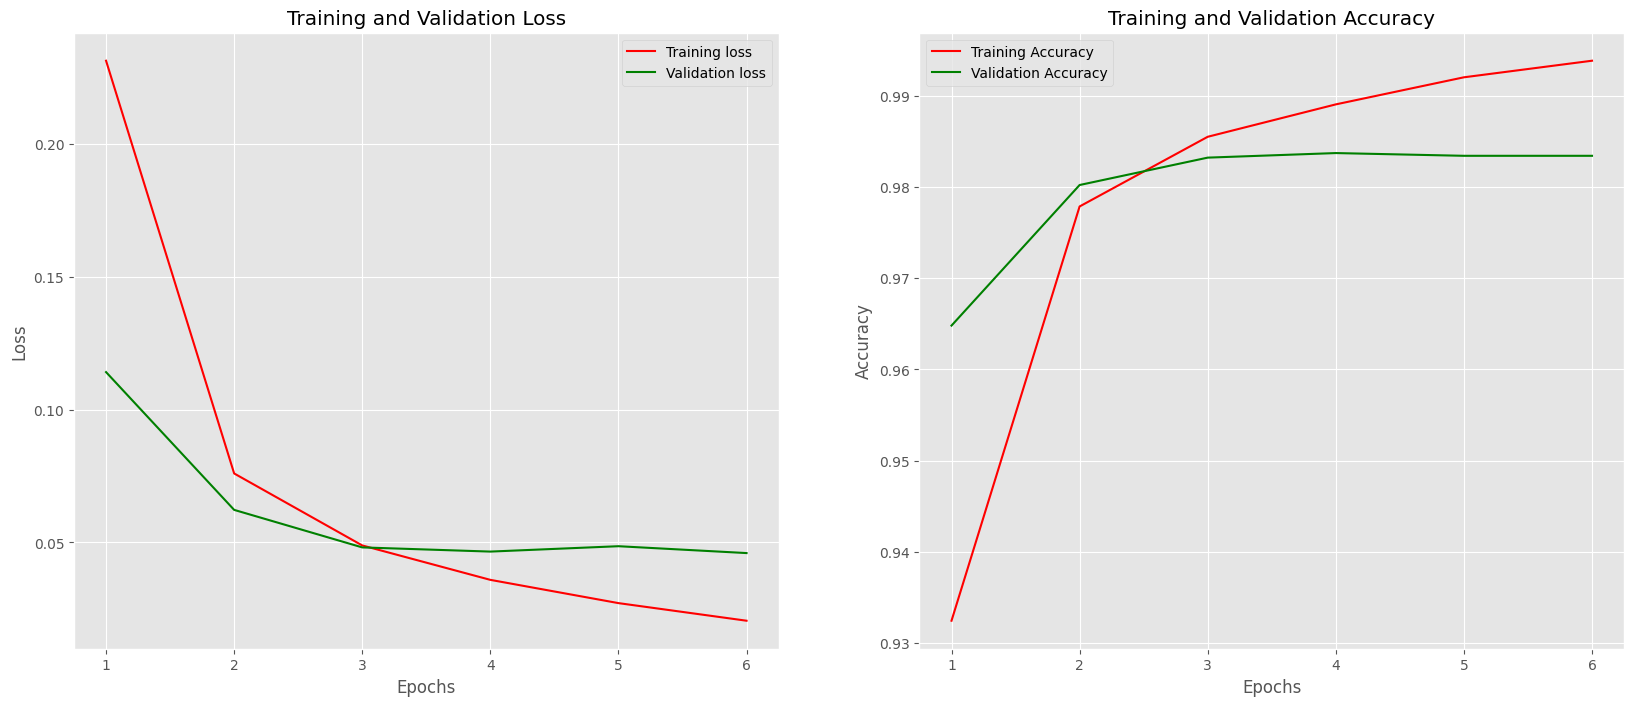

In [15]:
# Plotting metrics:

train_acc = history.history['sparse_categorical_accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_sparse_categorical_accuracy']
val_loss = history.history['val_loss']
Epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize= (20, 8))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()